<a href="https://colab.research.google.com/github/thashmadech/is417-project/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install swifter

In [4]:
import pandas as pd
import numpy as np
import dask
import re, string, unicodedata
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk import ngrams, word_tokenize, sent_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from tqdm import tqdm
# from textblob import TextBlob
# import swifter
from sklearn.feature_extraction.text import CountVectorizer

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt



ModuleNotFoundError: ignored

In [2]:
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/Bitcoin_tweets.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str')


In [3]:
df_tweets.tail(20)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
1232789,BitcoinPress,NaN,Bitcoin and Blockchain news media platform.,2013-10-27 19:11:22,582.0,77,193,False,2021-09-10 21:18:03,"#CryptocurrencyNews #BTC #DOGE Why Bitcoin, Et...","['CryptocurrencyNews', 'BTC', 'DOGE']",dlvr.it,False
1232790,renLargeAssetsBot,NaN,Bot tweeting $100k+ mint/burn transactions on ...,2021-02-20 02:22:39,362.0,0,0,False,2021-09-10 21:18:02,"💰💰💰 Minted 25.961 #renBTC (1,171,590.48 USD) o...","['renBTC', 'SOL', 'BTC']",renLargeAssets,False
1232791,DYOR.net Dev & Bot,Internet,Co-managed account by both https://t.co/SV7y6G...,2018-01-03 13:46:13,67468.0,536,633,False,2021-09-10 21:18:02,[SCAN RESULTS - 15m - #BTC PAIR]\n\nExchange: ...,"['BTC', 'Binance']",DYORCryptoBot,False
1232792,Jaime Arredondo,NaN,Medical student & biomedical researcher (immun...,2016-04-08 17:14:44,1947.0,550,3151,False,2021-09-10 21:17:58,"Well, well, well, finally good news! \n\nLI am...","['BTC', 'BNB', 'Crypto']",Twitter for iPhone,False
1232793,CaFiatEmptor,NaN,I‘m drawn to the #DeFi vision of „banking the ...,2015-07-15 18:28:15,21.0,382,347,False,2021-09-10 21:17:56,💸Pamp➡️Dip➡️Pump➡️Dip➡️Pimp➡️Pip➡️?\n🤔Can’t ti...,"['BTC', 'ETH']",Twitter for iPhone,False
1232794,Bitcoin Beach,NaN,A real village with real Bitcoin uses in daily...,2019-08-06 07:28:32,44734.0,223,733,False,2021-09-10 21:17:34,@Adalber22496821 They watched how well it is w...,['BTC'],Twitter for iPhone,False
1232795,Umair waheed 🇵🇰 🍴,"Karachi, Pakistan",ACCA \nhttps://t.co/ayQeEHjMx0,2012-05-01 07:34:43,818.0,1034,64672,False,2021-09-10 21:17:25,Why do I feel like #BTC is gonna slump down ag...,['BTC'],Twitter for Android,False
1232796,Immanuel Willson,NaN,crypto trader|| investor,2021-04-23 15:09:17,48.0,140,69,False,2021-09-10 21:17:24,@HuobiGlobal @Joselito @Swipe @DerivedFinance ...,"['Crypto', 'btc']",Twitter for Android,False
1232797,Sokyu Honma,"Sakata, Japan",📰 The fastest #news and #signals from #cryptoc...,2020-12-12 23:55:52,722.0,177,1628,False,2021-09-10 21:17:13,#BTC #ETH #ADA ... Info\nOpen Sea’s NFT volume...,"['BTC', 'ETH', 'ADA']",Zapier.com,False
1232798,DYOR.net Dev & Bot,Internet,Co-managed account by both https://t.co/SV7y6G...,2018-01-03 13:46:13,67468.0,536,633,False,2021-09-10 21:17:09,[SCAN RESULTS - 15m]\n\nExchange: #KuCoin\n\nT...,"['KuCoin', 'BTC', 'USDT', 'KuCoin', 'Binance']",DYORCryptoBot,False


In [4]:
df_tweets.dtypes


user_name           object
user_location       object
user_description    object
user_created        object
user_followers      object
user_friends        object
user_favourites     object
user_verified       object
date                object
text                object
hashtags            object
source              object
is_retweet          object
dtype: object

In [5]:
df_tweets.shape

(1232809, 13)

In [6]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232809 entries, 0 to 1232808
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   user_name         1232784 non-null  object
 1   user_location     647838 non-null   object
 2   user_description  1088181 non-null  object
 3   user_created      1232807 non-null  object
 4   user_followers    1232805 non-null  object
 5   user_friends      1232805 non-null  object
 6   user_favourites   1232805 non-null  object
 7   user_verified     1232805 non-null  object
 8   date              1232805 non-null  object
 9   text              1232805 non-null  object
 10  hashtags          1216000 non-null  object
 11  source            1229435 non-null  object
 12  is_retweet        1232749 non-null  object
dtypes: object(13)
memory usage: 122.3+ MB


In [7]:
#df_tweets[df_tweets['date']=="['ETH', 'BTC', 'Bitcoin']"]

In [8]:
# for x in tqdm(df_tweets['date']):
#   try:
#     pd.to_datetime(x)
#   except:
#     print(x)

In [9]:
#pip install swifter


In [10]:

# def datetime_checker(x):
#     try:
#       return pd.to_datetime(x, errors='coerce')
#     except:
#       return x


# df_tweets['datetime'] = df_tweets['date'].swifter.apply(datetime_checker)


In [11]:

df_tweets['datetime'] = pd.to_datetime(df_tweets['date'], errors = 'coerce')


In [12]:
def is_datetime(x):
    try:
      pd.to_datetime(x)
      return True
    except:
      return False

df_tweets['is_datetime'] = df_tweets['date'].swifter.apply(is_datetime)

Pandas Apply:   0%|          | 0/1232809 [00:00<?, ?it/s]

In [13]:
df_tweets = df_tweets[df_tweets.is_datetime != False]

In [14]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232803 entries, 0 to 1232808
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_name         1232778 non-null  object        
 1   user_location     647832 non-null   object        
 2   user_description  1088175 non-null  object        
 3   user_created      1232801 non-null  object        
 4   user_followers    1232799 non-null  object        
 5   user_friends      1232799 non-null  object        
 6   user_favourites   1232799 non-null  object        
 7   user_verified     1232799 non-null  object        
 8   date              1232799 non-null  object        
 9   text              1232799 non-null  object        
 10  hashtags          1215994 non-null  object        
 11  source            1229435 non-null  object        
 12  is_retweet        1232749 non-null  object        
 13  datetime          1232799 non-null  dateti

In [15]:
df_tweets['datetime'].describe(datetime_is_numeric=True)

count                          1232799
mean     2021-07-17 21:37:14.467366912
min                2021-02-05 10:52:04
25%                2021-07-04 12:41:46
50%                2021-07-26 11:31:48
75%         2021-08-16 21:20:29.500000
max                2021-09-10 23:59:49
Name: datetime, dtype: object

In [16]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
df_tweets['text'].replace({'https': '<br>'}, regex=True)

0          Blue Ridge Bank shares halted by NYSE after #b...
1          😎 Today, that's this #Thursday, we will do a "...
2          Guys evening, I have read this article about B...
3          $BTC A big chance in a billion! Price: \487264...
4          This network is secured by 9 508 nodes as of t...
                                 ...                        
1232804    @SpeedUpBSC @debi_pada @AdaTiers @golf_grinder...
1232805    This time, what will happen between the US SEC...
1232806                          One #btc is only 205 #EGLD.
1232807    Want to join a group that posted TSLA 745P day...
1232808    cabanacrypto is live! @CabanaCrypto\n\n"HEX Ha...
Name: text, Length: 1232803, dtype: object

In [18]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [19]:
def preprocess_text(text_data, stopwords):

    # tqdm is for printing the status bar
    preprocessed_text = []

    for sentence in tqdm(text_data):

        if sentence is None:
          preprocessed_text.append("")
        else:
          sent = decontracted(sentence)
          sent = sent.replace('\\r', ' ')
          sent = sent.replace('\\n', ' ')
          sent = sent.replace('\\"', ' ')
          sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
          sent = re.sub(r'\W*\b\w{1,2}\b', '', sent)
          sent = re.sub('https?:\/\/\S+', '', sent)
          sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
          preprocessed_text.append(sent.lower().strip())
    
    return preprocessed_text

In [20]:
preprocessed_text = preprocess_text(df_tweets['text'].values, stopwords)

100%|██████████| 1232803/1232803 [02:18<00:00, 8877.16it/s]


In [21]:
len(preprocessed_text)

1232803

In [22]:
def cleanse_sentence(sentence):

  test = sentence.split()

  try:
    last = test[-1]
    test.remove(last)
    val = test.index('https')
    words = [test[val], test[val+1], test[val+2]]
  except:
    return sentence.replace("https", "")
  
  test.remove(words[0])
  test.remove(words[1])
  test.remove(words[2])

  return " ".join(test)

In [23]:
preprocessed_text = list(map(cleanse_sentence, preprocessed_text))

In [24]:
preprocessed_text

['blue ridge bank shares halted nyse bitcoin atm announcement https',
 'today thursday take friend leowandersleb btc wallet security expe  go6adgrml5',
 'guys evening read article btc would like share',
 'btc big chance billion price 4872644 2021 bitcoin btc crypto',
 'network secured 508 nodes today soon biggest bears recognise btc big fail  1xovda8rkw',
 'trade crypto binance enjoy cashback trading fee sign link',
 'fire amp aman bitcoin crypto btc  cv9iyody55',
 'prices update eur hour btc 37082 eth 1441 xrp  y3wlhav2sx',
 'btc bitcoin ethereum eth crypto cryptotrading rsr know told guys target 060 know  bvetsnhs67',
 'tesla bitcoin investment revolutionary crypto firms may not yet jpmorgan  wykwfh0elw',
 'annnd btc bitcoin headed even higher  ehadui087d',
 'prices update usdt hour btc 44853 eth 1740 xrp  v5ogvw7klm',
 'join first virtual crypto meetup 2021 crypto fridays something everyone whether  rpindw6hcc',
 'bitcoin btc btc gbtc riot mara eth ethe aave defi aave comp cgld grt 

In [25]:
df_tweets['text'] = preprocessed_text




In [26]:
def cleanse_last(x):
  try:
    val = x.split()
    rep = val[-1]
    val.remove(rep)
  except:
    return x

  return " ".join(val)

In [27]:
preprocessed_text = list(map(cleanse_last, preprocessed_text))
preprocessed_text

['blue ridge bank shares halted nyse bitcoin atm announcement',
 'today thursday take friend leowandersleb btc wallet security expe',
 'guys evening read article btc would like',
 'btc big chance billion price 4872644 2021 bitcoin btc',
 'network secured 508 nodes today soon biggest bears recognise btc big fail',
 'trade crypto binance enjoy cashback trading fee sign',
 'fire amp aman bitcoin crypto btc',
 'prices update eur hour btc 37082 eth 1441 xrp',
 'btc bitcoin ethereum eth crypto cryptotrading rsr know told guys target 060 know',
 'tesla bitcoin investment revolutionary crypto firms may not yet jpmorgan',
 'annnd btc bitcoin headed even higher',
 'prices update usdt hour btc 44853 eth 1740 xrp',
 'join first virtual crypto meetup 2021 crypto fridays something everyone whether',
 'bitcoin btc btc gbtc riot mara eth ethe aave defi aave comp cgld grt crypto cryptocurrency xlm',
 'buying pressure alert price trading around 44843 crypto',
 'buy bitcoin lifetime cashback fees largest

In [28]:
 
# df_first_half = df_tweets.sort_values('datetime',ascending=True).head(int(df_tweets.shape[0]*.5))
# df_second_half = df_tweets.sort_values('datetime',ascending=False).head(int(df_tweets.shape[0]*.5))


In [29]:
#pip install --upgrade vaderSentiment

In [30]:
#pip install --upgrade pyspark


In [31]:
def getSubjectivity(twt):
  try:
    return TextBlob(twt).sentiment.subjectivity
  except:
    return twt
   

def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity


# df_tweets['Subjectivity'] = df_tweets['text'].swifter.apply(lambda x: getSubjectivity(x))



In [32]:
df_tweets['Polarity'] = df_tweets['text'].swifter.apply(lambda x: getPolarity(x))


Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [33]:
df_tweets.sample(50)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,datetime,is_datetime,Polarity
94536,Cryptonic,NaN,100% in crypto $vidt $nex,2017-10-16 03:16:30,400.0,136.0,7602.0,False,2021-04-20 15:40:08,first doge hodler put winnings vidt vidt datal...,"['doge', 'DogeDay', 'dogecoin', 'crypto', 'bit...",Twitter for Android,False,2021-04-20 15:40:08,True,0.250000
122154,DubaiTraderLLC,NaN,NaN,2020-03-10 12:52:32,65.0,494.0,1079.0,False,2021-05-26 16:33:10,dowjones happy 125th birthday dow jones know d...,"['DowJones', 'DowJones', 'USMarket', 'WallStre...",Twitter for iPhone,False,2021-05-26 16:33:10,True,0.650000
587051,Vincent Jaeger ⓣ,NaN,I’m only here for Crypto Twitter 🤓,2021-05-04 20:21:35,65.0,128.0,1997.0,False,2021-07-24 00:07:53,kill bears btc rw3h8szvpi,['btc'],Twitter for iPhone,False,2021-07-24 00:07:53,True,0.000000
538626,ROHIT,NaN,NaN,2021-04-20 13:39:03,1.0,150.0,137.0,False,2021-07-19 01:36:48,hopefully project success becomes one best cry...,"['cryptocurrency', 'Bitcoin', 'Airdrop', 'BSC'...",Twitter Web App,False,2021-07-19 01:36:48,True,0.537500
296870,Whale Transactions,NaN,Always on Whale Watch. $BTC $ETH,2021-02-08 19:58:44,801.0,5.0,0.0,False,2021-07-04 08:02:46,large bitcoin 299 65331792 btc transaction has...,"['BTC', 'BITCOIN', 'WHALEALERT', 'WATCHINWHALES']",watchinwhales,False,2021-07-04 08:02:46,True,0.214286
617239,#ZedZed,Malta,Blockchain | Dreamer | Crypto | Digital Curren...,2018-12-02 13:39:32,7310.0,7727.0,40929.0,False,2021-07-30 04:58:15,failed cash btc time high tough luck fail time...,"['Bitcoin', 'crypto', 'blockchain', 'digitalcu...",Twitter Web App,False,2021-07-30 04:58:15,True,-0.132698
777219,Era,NaN,#TEAMSTALLION #TesmSiL,2018-09-06 18:11:10,302.0,203.0,369.0,False,2021-08-08 06:14:23,best one referral code network network era4 be...,"['twitchstreaming', 'Bitcoin', 'Ethereum', 'BT...",Twitter for Android,False,2021-08-08 06:14:23,True,0.466667
966260,BA Danger 💉🦠Blue Pill☣️,Land of Entrapment,"Mechanical Contractor, Bitcoin Maxi, Dad, Navy...",2009-07-06 17:26:57,297.0,835.0,30078.0,False,2021-08-16 23:15:44,bitcoin fix akh1kpy6cb,['Bitcoin'],Twitter for iPhone,False,2021-08-16 23:15:44,True,0.000000
113566,YouTube: The Hodlers,NaN,YouTube: The Hodlers - For up to date Bitcoin ...,2021-05-21 03:36:32,10.0,76.0,3.0,False,2021-05-28 13:17:58,business markets michael saylor interview cnn ...,"['Bitcoin', 'btc', 'cryptocurrency', 'cryptocu...",Twitter Web App,False,2021-05-28 13:17:58,True,0.000000
264016,Abdullah,"Dhaka, Bangladesh",I am Abdullah.I am student.,2021-07-03 20:41:23,1.0,57.0,66.0,False,2021-07-05 15:29:01,airdropinspect believe faithful project projec...,"['Airdrop', 'Airdrops', 'Airdropinspector', 'B...",Twitter for Android,False,2021-07-05 15:29:01,True,0.500000


In [34]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
df_tweets['text_token'] = df_tweets['text'].swifter.apply(tokenizer.tokenize)



Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [35]:
df_tweets['text_token'].sample(10)


154482     [pirates, put, four, runs, seventh, inning, ta...
775913     [btc, bitcoin, since, cryptocrash, became, top...
683935     [arbkf, clsk, kroef, btc, continues, push, hig...
111054     [bitcoin, 15m, timeframe, looking, strong, rev...
1156879    [microstrategy, bought, another, 177, million,...
438194     [bitcoin, bullish, right, today, beginning, ne...
1062122    [corndefi, good, bro, andriah, 4837119, 7, lus...
167361     [bitcoin, current, price, 32789, 27466, crypto...
32108      [btc, value, must, read, bitcoin, critics, 4az...
643339     [since, entered, upward, trend, medium, short,...
Name: text_token, dtype: object

In [36]:
# df_first_half['stemmed_text'].sample(50)

In [37]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')

def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
df_tweets['lemm_text'] = df_tweets['text_token'].swifter.apply(lambda x: lemmatizer_on_text(x))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pandas Apply:   0%|          | 0/1232803 [00:00<?, ?it/s]

In [38]:
df_tweets['lemm_text'].head()

0    [blue, ridge, bank, shares, halted, nyse, bitc...
1    [today, thursday, take, friend, leowandersleb,...
2    [guys, evening, read, article, btc, would, lik...
3    [btc, big, chance, billion, price, 4872644, 20...
4    [network, secured, 508, nodes, today, soon, bi...
Name: lemm_text, dtype: object

In [39]:
#pip install vaderSentiment


In [40]:
#sentiment analysis using vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

scores = []
for sentence in tqdm(df_tweets['text']):
  score = analyser.polarity_scores(sentence)
  scores.append(score)
  
scores = pd.DataFrame(scores)

df_tweets['Compound_vader'] = scores['compound']
df_tweets['Negative_vader'] = scores['neg']
df_tweets['Neutral_vader'] = scores['neu']
df_tweets['Positive_vader'] = scores['pos']


100%|██████████| 1232803/1232803 [03:00<00:00, 6820.54it/s]


In [41]:
df_tweets.sample()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,datetime,is_datetime,Polarity,text_token,lemm_text,Compound_vader,Negative_vader,Neutral_vader,Positive_vader
507247,STRATO฿ITZ,USA,Digital Token Entrepreneur | Top Mod @ https:/...,2014-04-25 19:40:15,469.0,112.0,1266.0,False,2021-07-20 04:44:16,top trending post coinbase sued deceptive doge...,"['Cryptocurrency', 'Bitcoin']",IFTTT,False,2021-07-20 04:44:16,True,0.5,"[top, trending, post, coinbase, sued, deceptiv...","[top, trending, post, coinbase, sued, deceptiv...",0.0,0.0,1.0,0.0


In [42]:
from collections import Counter
d = Counter(" ".join(df_tweets["text"]).split()).most_common(20)




In [43]:
df_freq_words = pd.DataFrame(d, columns=['Word', 'Frequency'])

df_freq_words

,Word,Frequency
0,bitcoin,1042000
1,btc,666305
2,crypto,350254
3,project,210965
4,cryptocurrency,190612
5,eth,173795
6,ethereum,141804
7,binance,138613
8,airdrop,137089
9,bnb,126459


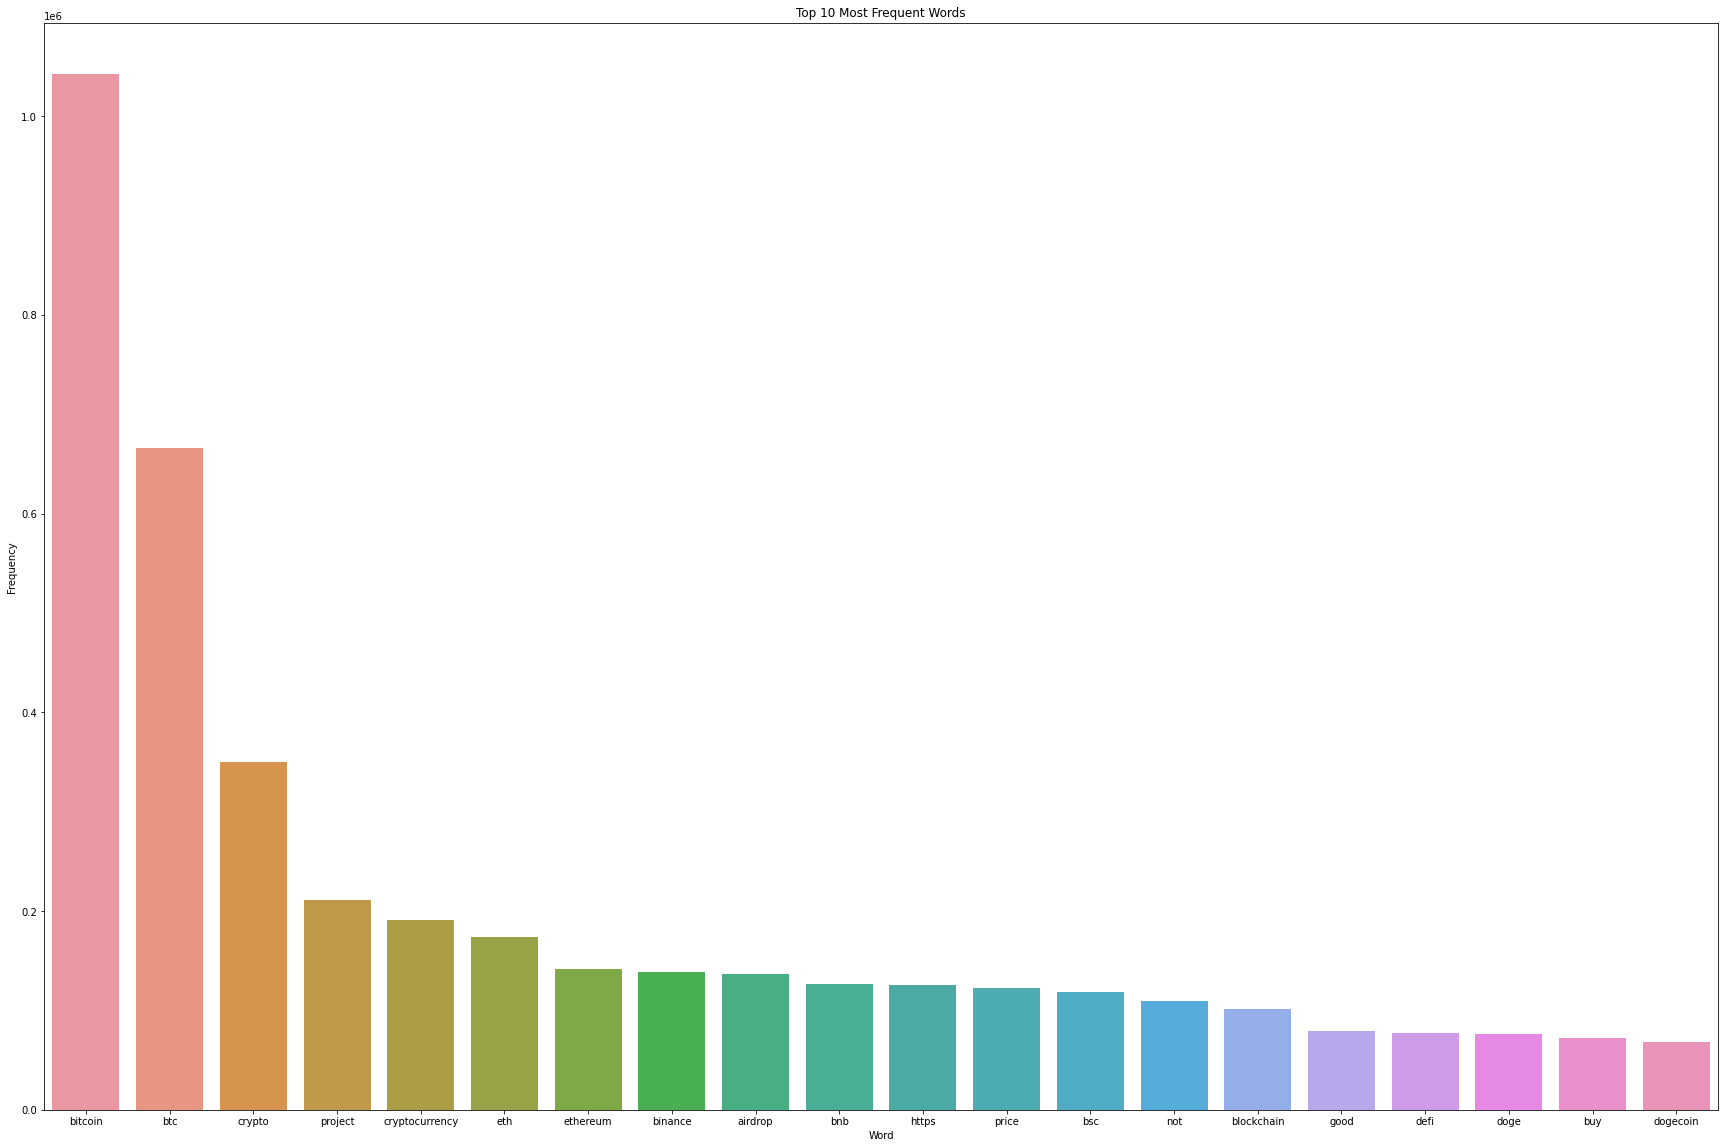

In [44]:

plt.figure(figsize=(30,20))
axis = sns.barplot(data=df_freq_words, x='Word', y='Frequency')
axis.set(ylabel='Frequency')
plt.title('Top 10 Most Frequent Words')
plt.show()

In [45]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score > 0:
        return 'Positive'
    else:
        return 'Neutral'

df_tweets['Analysis_Polarity'] = df_tweets['Polarity'].apply(getAnalysis)




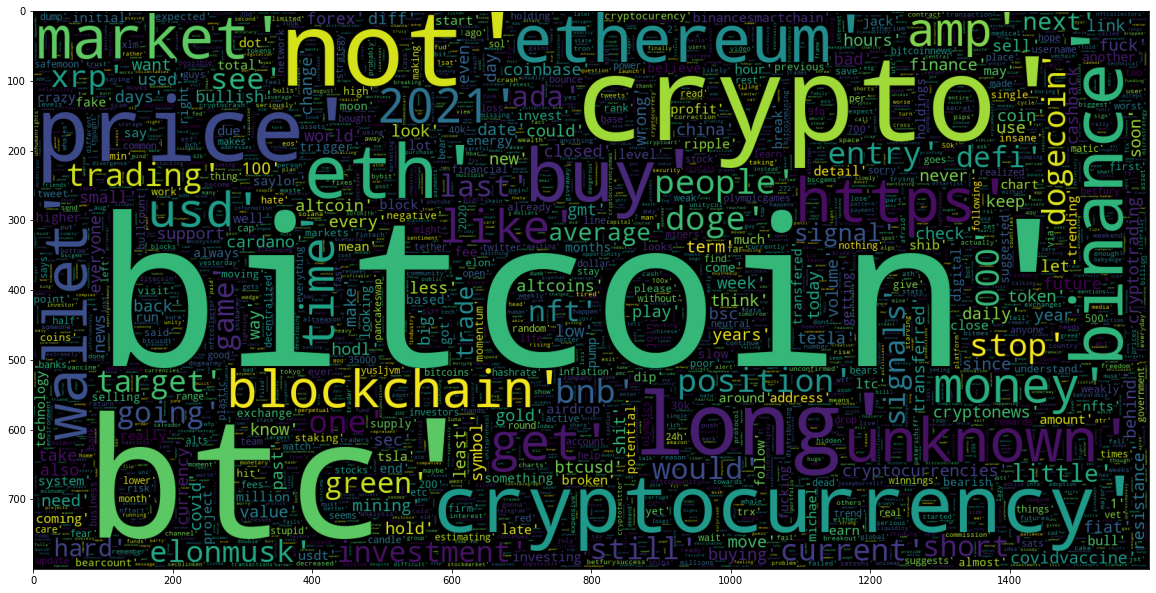

In [46]:
#plot a cloud for negative tweets

data_neg = df_tweets.loc[df_tweets['Analysis_Polarity'] == 'Negative']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 6000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(str(v) for v in data_neg['lemm_text']))
plt.imshow(wc)

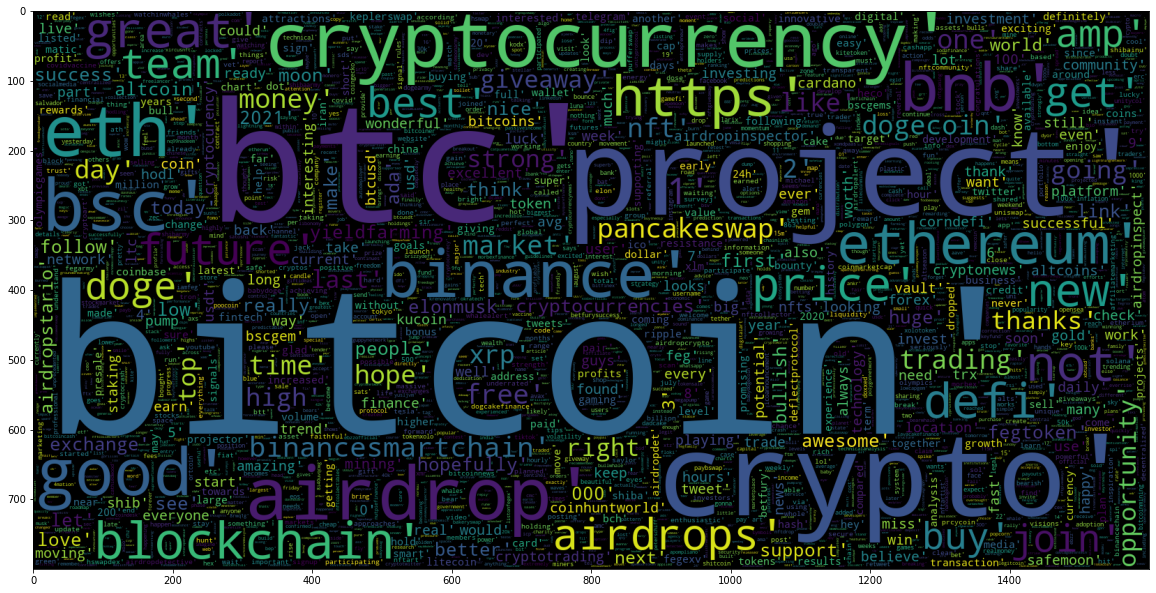

In [47]:
#plot a cloud for positive tweets
data_pos = df_tweets.loc[df_tweets['Analysis_Polarity'] == 'Positive']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 8000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(str(v) for v in data_pos['lemm_text']))
plt.imshow(wc)

In [48]:
df_tweets.describe()


,Polarity,Compound_vader,Negative_vader,Neutral_vader,Positive_vader
count,1.232803e+06,1.232797e+06,1.232797e+06,1.232797e+06,1.232797e+06
mean,1.501862e-01,2.603282e-01,4.212447e-02,8.001431e-01,1.577017e-01
std,2.726739e-01,4.209588e-01,9.353513e-02,1.792210e-01,1.679439e-01
min,-1.000000e+00,-9.918000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,6.710000e-01,0.000000e+00
50%,0.000000e+00,2.023000e-01,0.000000e+00,8.150000e-01,1.260000e-01
75%,3.000000e-01,6.249000e-01,0.000000e+00,1.000000e+00,2.680000e-01
max,1.000000e+00,9.917000e-01,9.350000e-01,1.000000e+00,1.000000e+00


In [49]:
# print('Printing positive tweets:\n')
# j=1
# sortedDF = df_first_half.sort_values(by=['Polarity']) #Sort the tweets
# for i in range(0, sortedDF.shape[0] ):
#     if( sortedDF['Analysis_Polarity'][i] == 'Positive'):
#         print(str(j) + ') '+ sortedDF['text'][i])
#         print()
#         j= j+1

In [50]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232803 entries, 0 to 1232808
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_name          1232778 non-null  object        
 1   user_location      647832 non-null   object        
 2   user_description   1088175 non-null  object        
 3   user_created       1232801 non-null  object        
 4   user_followers     1232799 non-null  object        
 5   user_friends       1232799 non-null  object        
 6   user_favourites    1232799 non-null  object        
 7   user_verified      1232799 non-null  object        
 8   date               1232799 non-null  object        
 9   text               1232803 non-null  object        
 10  hashtags           1215994 non-null  object        
 11  source             1229435 non-null  object        
 12  is_retweet         1232749 non-null  object        
 13  datetime           1232799 

In [51]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232803 entries, 0 to 1232808
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   user_name          1232778 non-null  object        
 1   user_location      647832 non-null   object        
 2   user_description   1088175 non-null  object        
 3   user_created       1232801 non-null  object        
 4   user_followers     1232799 non-null  object        
 5   user_friends       1232799 non-null  object        
 6   user_favourites    1232799 non-null  object        
 7   user_verified      1232799 non-null  object        
 8   date               1232799 non-null  object        
 9   text               1232803 non-null  object        
 10  hashtags           1215994 non-null  object        
 11  source             1229435 non-null  object        
 12  is_retweet         1232749 non-null  object        
 13  datetime           1232799 

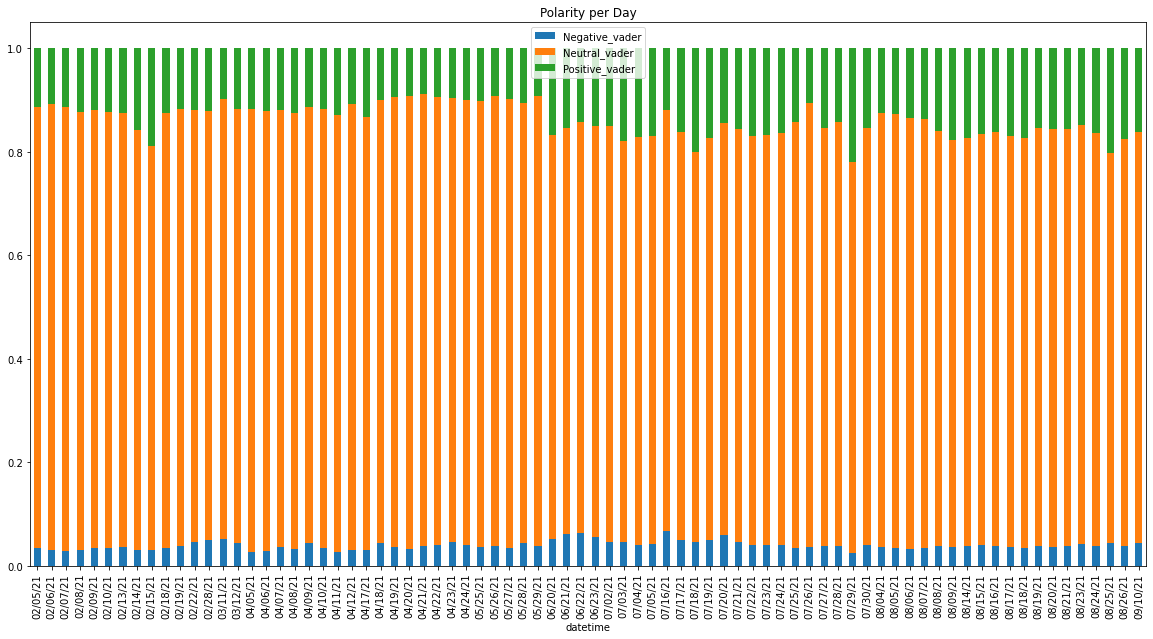

In [52]:

df_tweets['datetime'] = pd.to_datetime(df_tweets['datetime'], errors = 'coerce')
df_tweets.sort_values(by = 'datetime')

df_tweets['datetime'] = df_tweets['datetime'].dt.strftime('%D')
x = df_tweets[['datetime', 'Negative_vader', 'Neutral_vader', 'Positive_vader']]
y = x.set_index('datetime')
z = y.groupby('datetime').mean()

z.plot.bar(stacked=True, title='Polarity per Day', figsize=(20,10))

In [7]:
df_for_model = df_tweets[['text']]

NameError: ignored

In [54]:
df_tweets.to_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv')

In [55]:
df_for_model

,text
0,blue ridge bank shares halted nyse bitcoin atm...
1,today thursday take friend leowandersleb btc w...
2,guys evening read article btc would like share
3,btc big chance billion price 4872644 2021 bitc...
4,network secured 508 nodes today soon biggest b...
...,...
1232804,speedupbsc debi pada adatiers golf grinder fir...
1232805,time happen sec coinbase btc eth coinbase sec
1232806,one btc 205 egld
1232807,want join group posted tsla 745p day trade wen...


In [1]:
import pandas as pd
df_tweets = pd.read_csv('/content/drive/MyDrive/is417-project/data_for_modeling.csv',engine='python',encoding='utf-8', error_bad_lines=False, dtype='str')
df_tweets

,Unnamed: 0,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,datetime,is_datetime,Polarity,text_token,lemm_text,Compound_vader,Negative_vader,Neutral_vader,Positive_vader,Analysis_Polarity
0,0,DeSota Wilson,"Atlanta, GA","Biz Consultant, real estate, fintech, startups...",2009-04-26 20:05:09,8534.0,7605,4838,False,2021-02-10 23:59:04,blue ridge bank shares halted nyse bitcoin atm...,['bitcoin'],Twitter Web App,False,02/10/21,True,0.0,"['blue', 'ridge', 'bank', 'shares', 'halted', ...","['blue', 'ridge', 'bank', 'shares', 'halted', ...",0.296,0.0,0.804,0.196,Neutral
1,1,CryptoND,NaN,😎 BITCOINLIVE is a Dutch platform aimed at inf...,2019-10-17 20:12:10,6769.0,1532,25483,False,2021-02-10 23:58:48,today thursday take friend leowandersleb btc w...,"['Thursday', 'Btc', 'wallet', 'security']",Twitter for Android,False,02/10/21,True,0.0,"['today', 'thursday', 'take', 'friend', 'leowa...","['today', 'thursday', 'take', 'friend', 'leowa...",0.6808,0.0,0.588,0.412,Neutral
2,2,Tdlmatias,"London, England","IM Academy : The best #forex, #SelfEducation, ...",2014-11-10 10:50:37,128.0,332,924,False,2021-02-10 23:54:48,guys evening read article btc would like share,NaN,Twitter Web App,False,02/10/21,True,0.0,"['guys', 'evening', 'read', 'article', 'btc', ...","['guys', 'evening', 'read', 'article', 'btc', ...",0.5719,0.0,0.561,0.439,Neutral
3,3,Crypto is the future,NaN,I will post a lot of buying signals for BTC tr...,2019-09-28 16:48:12,625.0,129,14,False,2021-02-10 23:54:33,btc big chance billion price 4872644 2021 bitc...,"['Bitcoin', 'FX', 'BTC', 'crypto']",dlvr.it,False,02/10/21,True,0.0,"['btc', 'big', 'chance', 'billion', 'price', '...","['btc', 'big', 'chance', 'billion', 'price', '...",0.25,0.0,0.818,0.182,Neutral
4,4,Alex Kirchmaier 🇦🇹🇸🇪 #FactsSuperspreader,Europa,Co-founder @RENJERJerky | Forbes 30Under30 | I...,2016-02-03 13:15:55,1249.0,1472,10482,False,2021-02-10 23:54:06,network secured 508 nodes today soon biggest b...,['BTC'],Twitter Web App,False,02/10/21,True,-0.25,"['network', 'secured', '508', 'nodes', 'today'...","['network', 'secured', '508', 'nodes', 'today'...",-0.2023,0.203,0.64,0.157,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1232798,1232804,Angela,"Brighton East, Victoria",Be careful. The devil has a pretty face. 😈 #Bi...,2009-05-21 02:14:09,78.0,1206,4802,False,2021-09-10 21:15:34,speedupbsc debi pada adatiers golf grinder fir...,"['BTC', 'BSCGems', 'BNB', 'SpeeeUpBSC', 'Airdr...",AngelaAngela,False,09/10/21,True,0.0,"['speedupbsc', 'debi', 'pada', 'adatiers', 'go...","['speedupbsc', 'debi', 'pada', 'adatiers', 'go...",NaN,NaN,NaN,NaN,Neutral
1232799,1232805,Mike Smith,"London, England",NaN,2021-09-08 21:35:25,0.0,24,2,False,2021-09-10 21:15:33,time happen sec coinbase btc eth coinbase sec,"['BTC', 'ETH', 'Coinbase', 'SEC']",Twitter Web App,False,09/10/21,True,-0.1,"['time', 'happen', 'sec', 'coinbase', 'btc', '...","['time', 'happen', 'sec', 'coinbase', 'btc', '...",NaN,NaN,NaN,NaN,Negative
1232800,1232806,CryptoMatic 💫,NaN,crypto market analyst 📈📊📉\nDM for business!! 🤝...,2020-07-27 10:02:22,292.0,161,14780,False,2021-09-10 21:15:04,one btc 205 egld,"['btc', 'EGLD']",Twitter for Android,False,09/10/21,True,0.0,"['one', 'btc', '205', 'egld']","['one', 'btc', '205', 'egld']",NaN,NaN,NaN,NaN,Neutral
1232801,1232807,OC34N,San Diego,♤♡◇♧\nPatriot\nCreator\njoin new Discord tradi...,2012-08-08 03:25:50,34.0,263,826,False,2021-09-10 21:14:46,want join group posted tsla 745p day trade wen...,"['TSLA', 'AMC', 'GME', 'WISH', 'BBIG', 'AMZN',...",Twitter Web App,False,09/10/21,True,0.15,"['want', 'join', 'group', 'posted', 'tsla', '7...","['want', 'join', 'group', 'posted', 'tsla', '7...",NaN,NaN,NaN,NaN,Positive


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
df_for_model = df_tweets['text'].astype(str)

In [3]:
#BoW text
count_vect = CountVectorizer() #in scikit-learn
data3 = df_for_model.values
data3 = np.nan_to_num(data3)

In [4]:
count_vect_text = count_vect.fit_transform(data3)

In [5]:
count_vect_text.get_shape()

(1232803, 860847)

In [6]:
df_modified = df_tweets[["user_followers","user_friends", "user_favourites","Polarity","Compound_vader","Negative_vader","Neutral_vader","Positive_vader"]].to_numpy()

In [7]:
#BoW user_verified
count_vect = CountVectorizer() #in scikit-learn
data2 = df_tweets['user_verified'].astype(str).values.ravel()
data2 = np.nan_to_num(data2)
count_vect_user_verified = count_vect.fit_transform(data2)

In [8]:
#BoW text source
count_vect = CountVectorizer() #in scikit-learn
data1 = df_tweets['source'].astype(str).values.ravel()
data1 = np.nan_to_num(data1)
count_vect_source = count_vect.fit_transform(data1)

In [9]:
from scipy.sparse import hstack

In [10]:
X_bow = hstack((count_vect_source, count_vect_user_verified, count_vect_text)).tocsr()

In [11]:
df_modified = df_modified.astype(float)
df_modified[np.isnan(df_modified)] = 0

X_bow = hstack((X_bow, df_modified))

In [12]:
y_bow = df_tweets['Analysis_Polarity']
y_bow.value_counts()

Positive    593287
Neutral     504676
Negative    134840
Name: Analysis_Polarity, dtype: int64

In [13]:
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [14]:
mapper = dict(zip(y_bow.unique(), [0,1,2]))
mapper

{'Negative': 1, 'Neutral': 0, 'Positive': 2}

In [15]:
y_bow = df_tweets['Analysis_Polarity'].map(mapper)

In [16]:
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
 
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_bow, y_bow, random_state = 0)
 
# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, dtree_predictions)

In [17]:
cm_df = pd.DataFrame(cm,
                     index = ['Neutral','Negative','Positive'], 
                     columns = ['Neutral','Negative','Positive'])
cm_df

,Neutral,Negative,Positive
Neutral,126206,0,0
Negative,26,33784,0
Positive,106,0,148079


Text(0.5, 1.0, 'Confusion Matrix')

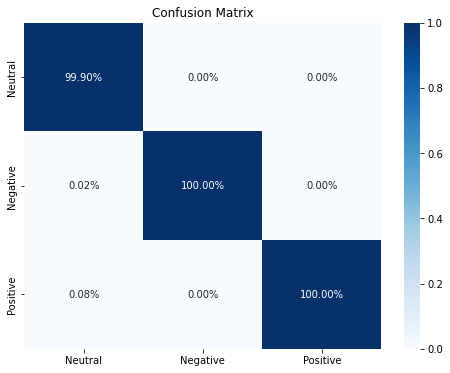

In [21]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))  
sns.heatmap(cm_df/np.sum(cm_df), annot=True, 
            fmt='.2%', cmap='Blues', ax=ax)
plt.title('Confusion Matrix')

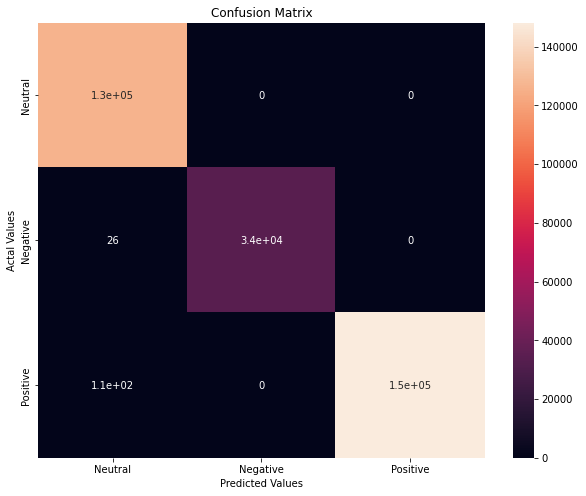

In [22]:
#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()